# import libraries

In [1]:
import os
import skimage.io
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import zipfile
import json
import random
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from skimage.transform import resize
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import  confusion_matrix ,ConfusionMatrixDisplay ,roc_curve, auc , accuracy_score , classification_report
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# helpful function

In [2]:
# display some images from the dataset

def draw_func(list_of_imgs, list_of_labels):
    # create figure
    fig = plt.figure(figsize=(10, 7))
    # setting values to rows and column variables
    rows, columns = 3, 3

    # Separate fake and real images based on labels
    fake_images = [img for img, label in zip(list_of_imgs, list_of_labels) if label == 'fake' or 'fake1' or 'fake2' or 'fake3' or 'fake4'or 'fake5'  ]
    real_images = [img for img, label in zip(list_of_imgs, list_of_labels) if label == 'real' or 'real1'or 'real2'or 'real3'or 'real4'or 'real5']

    # Randomly select fake and real images with appropriate sample sizes
    fake_sample_size = min(5, len(fake_images))  # Adjust sample size if fewer than 5 fake images
    real_sample_size = min(4, len(real_images))  # Adjust sample size if fewer than 4 real images
    fake_sample = random.sample(fake_images, fake_sample_size)
    real_sample = random.sample(real_images, real_sample_size)

    # Combine the selected images and labels
    sample_images = fake_sample + real_sample
    sample_labels = ['fake'] * fake_sample_size + ['real'] * real_sample_size

    # Iterate over the selected images and labels
    for i, (img, label) in enumerate(zip(sample_images, sample_labels)):
        # Adds a subplot at the i+1 position
        ax = fig.add_subplot(rows, columns, i+1)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(label)  # Set the title as the corresponding label

    plt.tight_layout()
    plt.show()

In [3]:
# Define a learning rate schedule
def lr_schedule(epoch):
    lr = 1e-4 * (0.95 ** epoch)  # Reduce the learning rate by 5% every epoch
    return lr

# Create a learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

In [4]:
# Plot learning curve
def plot_learning_curve(history):
    plt.figure(figsize=(12, 4))

    # Plot training & validation loss values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')

    plt.tight_layout()
    plt.show()

In [5]:
# function for evaluate the modl on test data
threshold = 0.5
def evaluate_test(model):
    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(x_test , y_test, verbose=0)
    y_test_pred = model.predict(x_test)
    threshold = 0.5
    y_test_pred_binary = (y_test_pred > threshold).astype(int)


    print('Test Loss:', test_loss)
    print('Test Accuracy:', test_accuracy)
    print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
    # Generate a classification report
    report = classification_report(y_test, y_test_pred_binary)

    # Print the classification report
    print("\n")
    print("Classification Report:")
    print(report)
    return test_loss, test_accuracy

In [6]:
# function for predict confusion matrix
def prediction_confmatrix(model):
    # Get the predicted labels for training, validation, and test sets
    y_train_pred = model.predict(x_train)
    y_val_pred  = model.predict(x_val)
    y_test_pred = model.predict(x_test)

    threshold = 0.5
    y_train_pred_binary = (y_train_pred > threshold).astype(int)
    y_val_pred_binary = (y_val_pred > threshold).astype(int)
    y_test_pred_binary = (y_test_pred > threshold).astype(int)


    # Compute the confusion matrix for training, validation, and test sets
    train_conf_matrix = confusion_matrix(y_train,y_train_pred_binary)
    val_conf_matrix = confusion_matrix(y_val, y_val_pred_binary)
    test_conf_matrix = confusion_matrix(y_test, y_test_pred_binary)

        # Set up the plot with a blue color map
    fig, axes = plt.subplots(1, 3, figsize=(16, 6), dpi=100)

    # Plot the confusion matrix for training set
    sns.heatmap(train_conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Predicted Negative", "Predicted Positive"],
                yticklabels=["Actual Negative", "Actual Positive"],
                ax=axes[0])
    axes[0].set(title='Confusion Matrix - Training Set')

    # Print the confusion matrix for training set
    print("Confusion Matrix - Training Set:")
    print(train_conf_matrix)

    # Plot the confusion matrix for validation set
    sns.heatmap(val_conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Predicted Negative", "Predicted Positive"],
                yticklabels=["Actual Negative", "Actual Positive"],
                ax=axes[1])
    axes[1].set(title='Confusion Matrix - Validation Set')

    # Print the confusion matrix for validation set
    print("Confusion Matrix - Validation Set:")
    print(val_conf_matrix)

    # Plot the confusion matrix for test set
    sns.heatmap(test_conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Predicted Negative", "Predicted Positive"],
                yticklabels=["Actual Negative", "Actual Positive"],
                ax=axes[2])
    axes[2].set(title='Confusion Matrix - Test Set')

    # Print the confusion matrix for test set
    print("Confusion Matrix - Test Set:")
    print(test_conf_matrix)

    plt.show()

    return y_train_pred_binary ,y_val_pred_binary, y_test_pred_binary ,train_conf_matrix,val_conf_matrix,test_conf_matrix

In [7]:
# Function to load images and resize them to (128, 128, 3)
def load_images(folder_path, limit=10000):
    images = []
    file_names = os.listdir(folder_path)

    # Ensure we don't exceed the limit
    for i, file_name in enumerate(file_names):
        if i >= limit:
            break
        file_path = os.path.join(folder_path, file_name)
        image = skimage.io.imread(file_path)
        image = resize(image, (128, 128, 3), anti_aliasing=True)
        images.append(image)

    return images

# load dataset

In [8]:
#define path and folders inside it
train_p ='E:\\New folder (6)\\New folder\\train'
test_p ='E:\\New folder (6)\\New folder\\test'
val_p = 'E:\\New folder (6)\\New folder\\valid'
folders = [f for f in os.listdir(train_p)]
print("folders=", folders)

folders= ['fake', 'real']


train data

In [9]:
#load the train data and put it in dataframe
train = pd.DataFrame(columns=['image', 'label'])

for folder in folders:
    images = load_images(os.path.join(train_p, folder))
    train_df = pd.DataFrame({'image': images ,'label': folder})
    train = pd.concat([train_df,train], ignore_index=False)
# Shuffle the data in the DataFrame
train = train.sample(frac=1).reset_index(drop=True)
train.head()

,image,label
0,"[[[0.174813688608706, 0.30422545331458833, 0.6...",real
1,"[[[0.09106986281818756, 0.05577574517112875, 0...",fake
2,"[[[0.6044185776255411, 0.4769628004378901, 0.3...",fake
3,"[[[0.5060771487390725, 0.37708594233602083, 0....",real
4,"[[[0.8006174649693136, 0.8045390335967646, 0.7...",fake


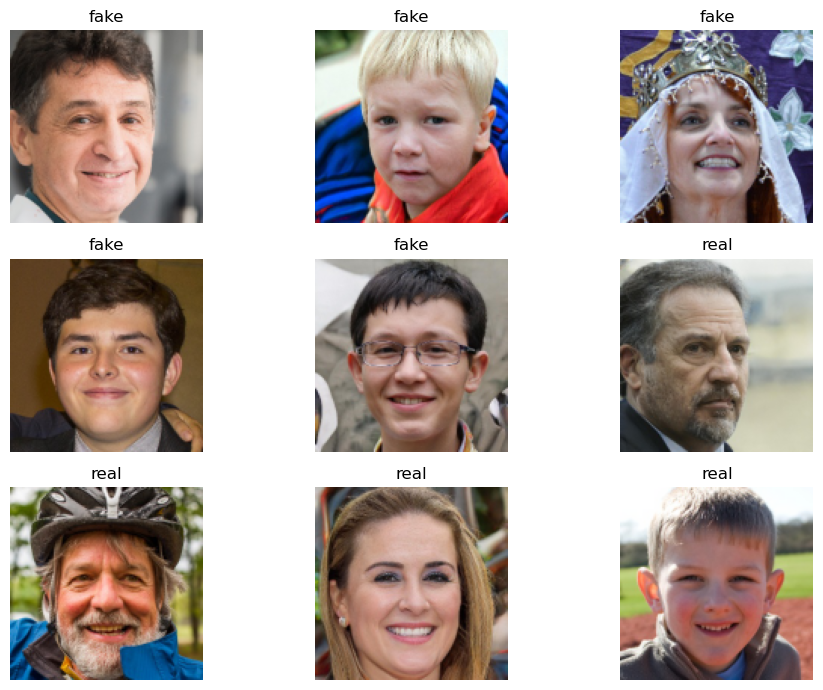

In [68]:
# show images sampels
draw_func(train['image'] ,train['label'])

test data

In [10]:
#load the test data and put it in dataframe
test = pd.DataFrame(columns=['pixels in image', 'label'])

for folder in folders:
    images = load_images(os.path.join(test_p, folder))
    test_df = pd.DataFrame({'pixels in image': images ,'label': folder})
    test = pd.concat([test_df,test], ignore_index=False)

# Shuffle the data in the DataFrame
test = test.sample(frac=1).reset_index(drop=True)
test


,pixels in image,label
0,"[[[0.07678474927349795, 0.04522389920512829, 0...",fake
1,"[[[0.7812432075163076, 0.7363330073156745, 0.6...",fake
2,"[[[0.9411195878723233, 0.946813114877955, 0.96...",real
3,"[[[0.14769827674344524, 0.19886547321859038, 0...",fake
4,"[[[0.9819452162189687, 0.9770789639326084, 0.9...",fake
...,...,...
19995,"[[[0.8232135311403934, 0.8428213742776482, 0.8...",fake
19996,"[[[0.5878370618744067, 0.6570680026795754, 0.2...",real
19997,"[[[0.15157420676151473, 0.2692197134374986, 0....",real
19998,"[[[0.35073184970882093, 0.3572269820060363, 0....",real


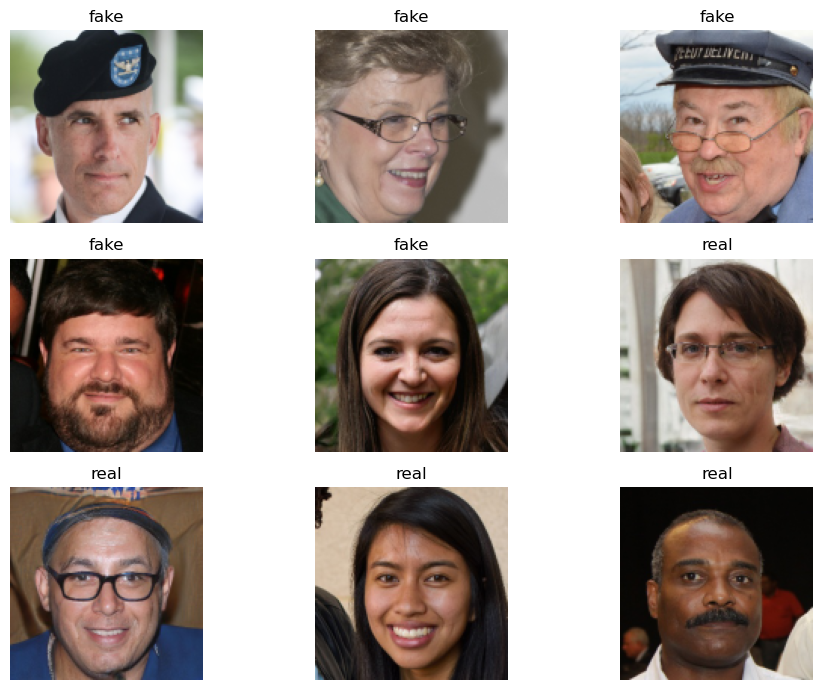

In [69]:
# show images sampels
draw_func(test['pixels in image'] ,test['label'])

validation data

In [11]:
#load the val data and put it in dataframe
val = pd.DataFrame(columns=['image', 'label'])

for folder in folders:
    images = load_images(os.path.join(val_p, folder))
    val_df = pd.DataFrame({'image': images ,'label': folder})
    val = pd.concat([val_df,val], ignore_index=False)

# Shuffle the data in the DataFrame
val = val.sample(frac=1).reset_index(drop=True)
val.head()

,image,label
0,"[[[0.4315190504173937, 0.3572046957895134, 0.4...",real
1,"[[[0.2855412122999803, 0.2961045921694472, 0.2...",fake
2,"[[[0.4563006063318984, 0.48406720872536957, 0....",real
3,"[[[0.5996733058558894, 0.6589173658278219, 0.6...",real
4,"[[[0.40144844497809884, 0.38184037082398953, 0...",real


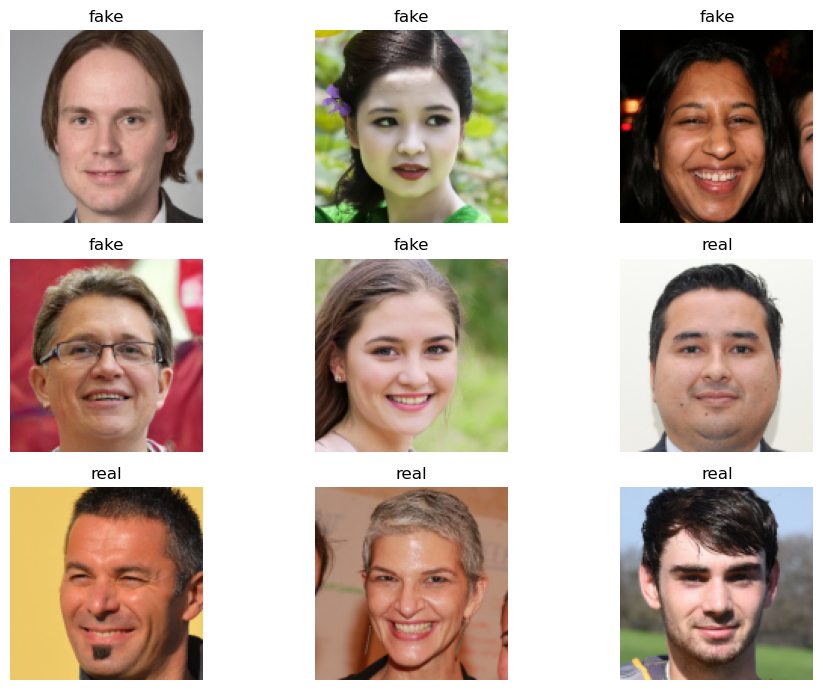

In [70]:
# show images sampels
draw_func(val['image'] ,val['label'])

# preprocess the data

In [12]:
#specify x for (train,val,test) then convert them to np.array to match the model
x_train = train['image']
x_val = val['image']
x_test = test['pixels in image']

x_train = np.stack(x_train.values)
x_val = np.stack(x_val.values)
x_test = np.stack(x_test.values)

In [13]:
x_train.shape , x_val.shape  , x_test.shape

((20000, 128, 128, 3), (20000, 128, 128, 3), (20000, 128, 128, 3))

In [14]:
#specify y for (train,val,test) then convert them to categorical to match the model
y_train = train['label']
y_val = val['label']
y_test = test['label']

label_encoder = LabelEncoder()
label_encoder.fit(y_train)
y_train= label_encoder.transform(y_train)

label_encoder.fit(y_val)
y_val= label_encoder.transform(y_val)

label_encoder.fit(y_test)
y_test= label_encoder.transform(y_test)

In [15]:
y_train.shape , y_val.shape  , y_test.shape

((20000,), (20000,), (20000,))

# models

In [16]:
# Compile the model
optimizer = Adam(learning_rate=1e-4)
# Define early stopping callback.
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

**MobileNetV2**

 **Hyperprameter section for** **MobileNetV2**

In [17]:
from tensorflow.keras.applications import MobileNetV2

# Load the MobileNetV2 model without the top (classification) layers
base_model1 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Add custom top layers for classification
model1 = Sequential()
model1.add(base_model1)
model1.add(GlobalAveragePooling2D())
model1.add(Dense(256, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))
model1.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 2,586,177
Trainable params: 2,552,065
Non-trainable params: 34,112
_________________________________________________________________


In [18]:
# Compile the model
model1.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
# Train the model
history1 = model1.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=2, callbacks=[lr_scheduler,early_stopping])

Epoch 1/20
10000/10000 [==============================] - 1893s 185ms/step - loss: 0.4849 - accuracy: 0.7611 - val_loss: 0.4920 - val_accuracy: 0.7815 - lr: 1.0000e-04
Epoch 2/20
10000/10000 [==============================] - 1246s 125ms/step - loss: 0.2213 - accuracy: 0.9123 - val_loss: 0.2603 - val_accuracy: 0.8935 - lr: 9.5000e-05
Epoch 3/20
10000/10000 [==============================] - 1359s 136ms/step - loss: 0.1307 - accuracy: 0.9512 - val_loss: 0.1737 - val_accuracy: 0.9362 - lr: 9.0250e-05
Epoch 4/20
10000/10000 [==============================] - 1372s 137ms/step - loss: 0.0890 - accuracy: 0.9672 - val_loss: 0.1504 - val_accuracy: 0.9435 - lr: 8.5737e-05
Epoch 5/20
10000/10000 [==============================] - 1382s 138ms/step - loss: 0.0642 - accuracy: 0.9769 - val_loss: 0.1215 - val_accuracy: 0.9569 - lr: 8.1451e-05
Epoch 6/20
10000/10000 [==============================] - 1369s 137ms/step - loss: 0.0495 - accuracy: 0.9814 - val_loss: 0.1749 - val_accuracy: 0.9455 - lr: 7.7

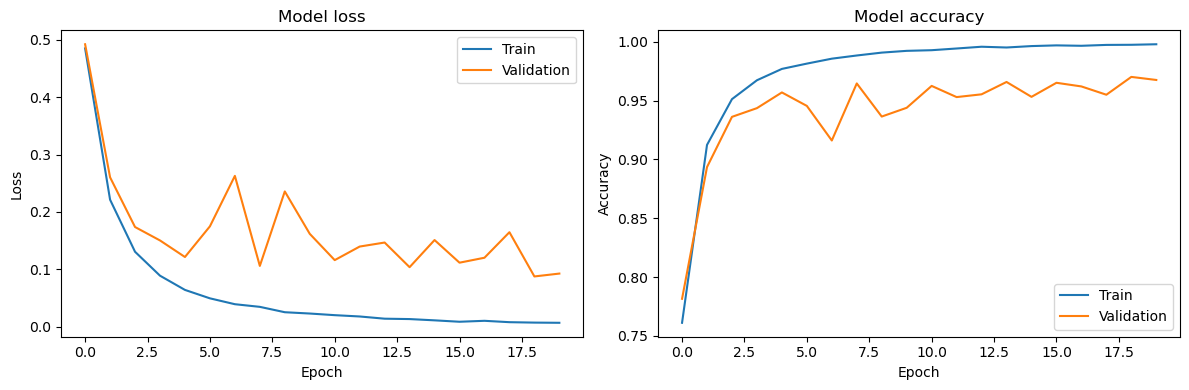

In [19]:
# Plot the learning curve
plot_learning_curve(history1)

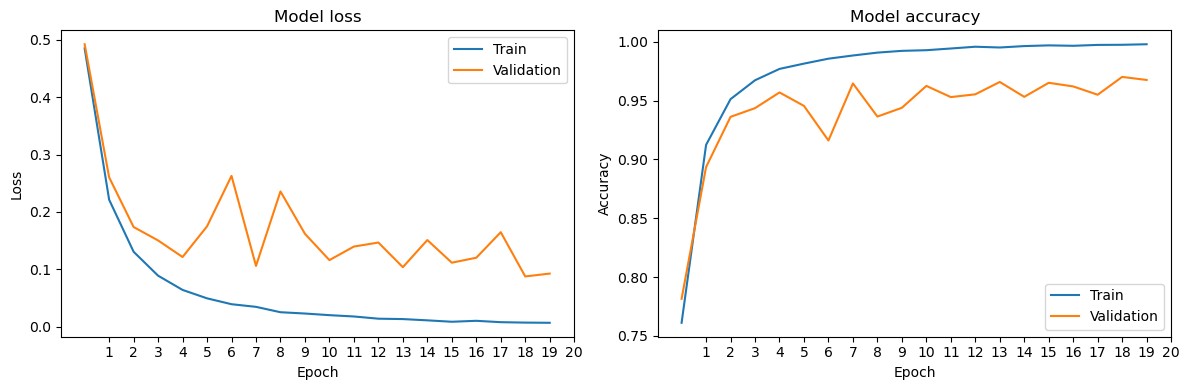

In [40]:
# Plot the learning curve
plot_learning_curvei(history1)

In [20]:
# evaluate the model in test data
evaluation1=evaluate_test(model1)

625/625 [==============================] - 109s 134ms/step
Test Loss: 0.0927521213889122
Test Accuracy: 0.9671499729156494
Test Accuracy: 96.71%


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97     10000
           1       0.97      0.96      0.97     10000

    accuracy                           0.97     20000
   macro avg       0.97      0.97      0.97     20000
weighted avg       0.97      0.97      0.97     20000



625/625 [==============================] - 87s 134ms/step
Confusion Matrix - Training Set:
[[9981   19]
 [  38 9962]]
Confusion Matrix - Validation Set:
[[9716  284]
 [ 366 9634]]
Confusion Matrix - Test Set:
[[9738  262]
 [ 395 9605]]


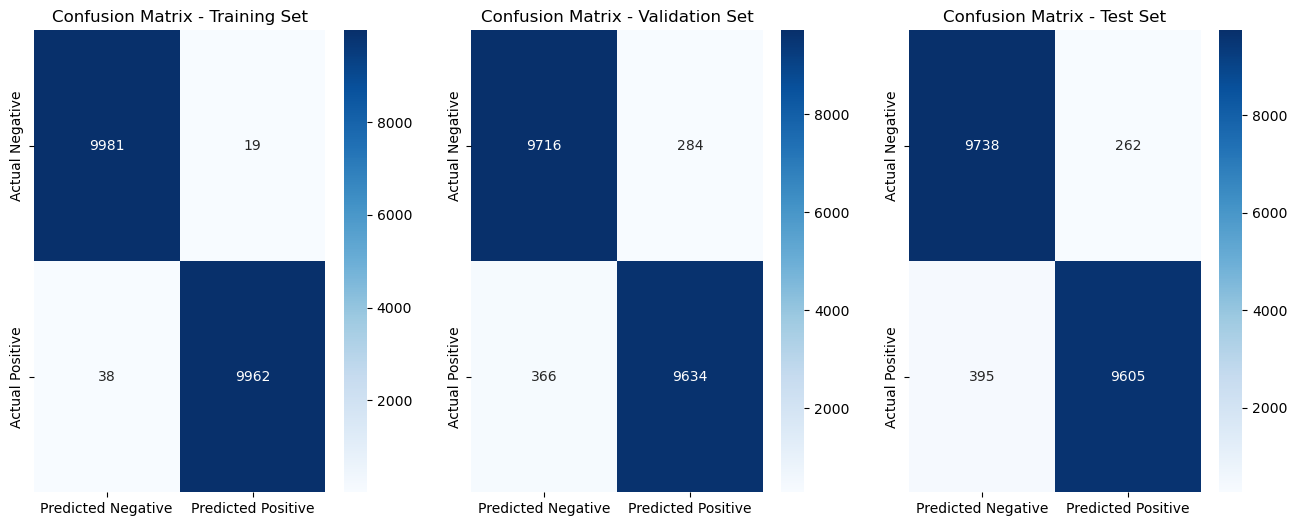

In [21]:
# predict values and confusion matrix
prediction1=prediction_confmatrix(model1)

In [22]:
# save whole model
model1.save("model1MobileNetV2")
model1.save("model1MobileNetV2withlargescalebatch2.h5")
##save only weights
model1.save_weights('model1MobileNetweightswithlargescalebatch2.h5')

INFO:tensorflow:Assets written to: model1MobileNetV2\assets


INFO:tensorflow:Assets written to: model1MobileNetV2\assets


batch size=4

In [23]:
# Compile the model
optimizer = Adam(learning_rate=1e-4)
# Define early stopping callback.
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

In [24]:
# Load the MobileNetV2 model without the top (classification) layers
base_model2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Add custom top layers for classification
model2 = Sequential()
model2.add(base_model2)
model2.add(GlobalAveragePooling2D())
model2.add(Dense(256, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))
model2.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 256)               327936    
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 2,586,177
Trainable params: 2,552,065
Non-trainable params: 34,112
_________________________________________________________________


In [25]:

# Compile the model
model2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history2 = model2.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=4, callbacks=[lr_scheduler,early_stopping])

Epoch 1/20
5000/5000 [==============================] - 792s 155ms/step - loss: 0.4487 - accuracy: 0.7863 - val_loss: 0.2364 - val_accuracy: 0.9029 - lr: 1.0000e-04
Epoch 2/20
5000/5000 [==============================] - 676s 135ms/step - loss: 0.2435 - accuracy: 0.9017 - val_loss: 0.1792 - val_accuracy: 0.9316 - lr: 9.5000e-05
Epoch 3/20
5000/5000 [==============================] - 669s 134ms/step - loss: 0.1270 - accuracy: 0.9517 - val_loss: 0.3424 - val_accuracy: 0.8766 - lr: 9.0250e-05
Epoch 4/20
5000/5000 [==============================] - 666s 133ms/step - loss: 0.0821 - accuracy: 0.9710 - val_loss: 0.1071 - val_accuracy: 0.9600 - lr: 8.5737e-05
Epoch 5/20
5000/5000 [==============================] - 667s 133ms/step - loss: 0.0549 - accuracy: 0.9797 - val_loss: 0.1352 - val_accuracy: 0.9488 - lr: 8.1451e-05
Epoch 6/20
5000/5000 [==============================] - 666s 133ms/step - loss: 0.0455 - accuracy: 0.9846 - val_loss: 0.0856 - val_accuracy: 0.9676 - lr: 7.7378e-05
Epoch 7/20

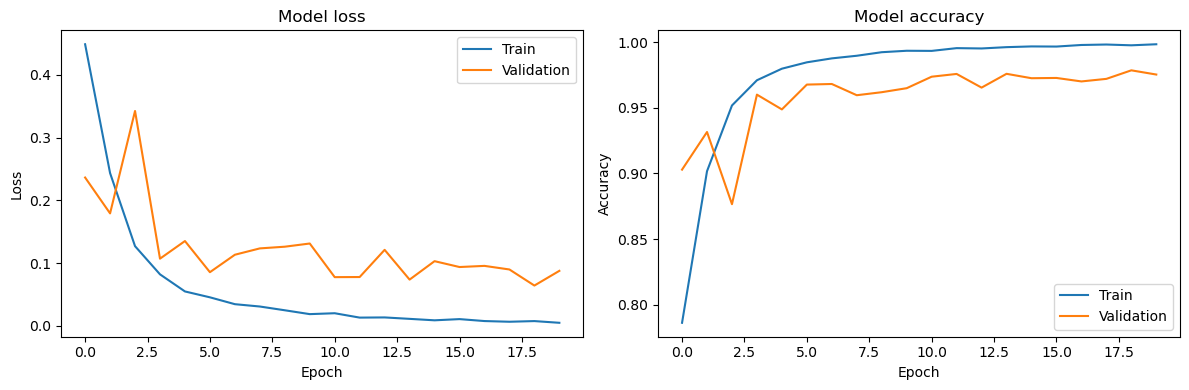

In [26]:
# Plot the learning curve
plot_learning_curve(history2)

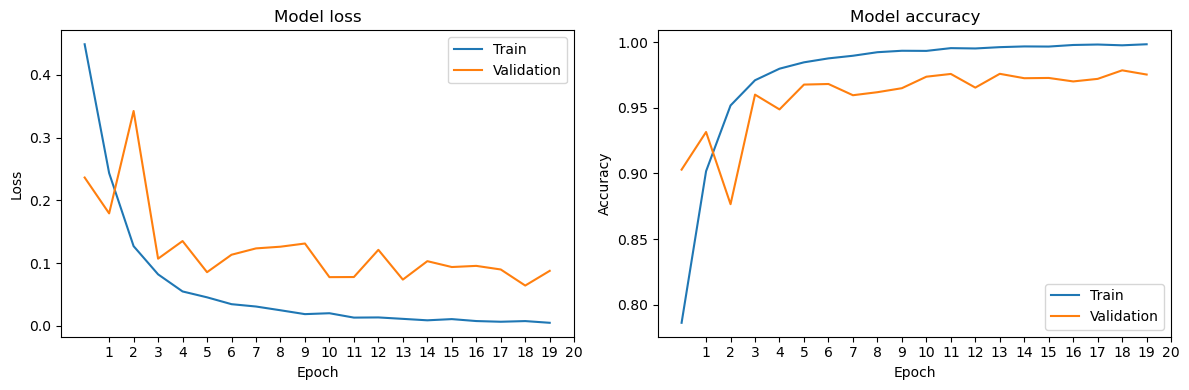

In [41]:
# Plot the learning curve
plot_learning_curvei(history2)

In [27]:
# evaluate the model in test data
evaluation2=evaluate_test(model2)

625/625 [==============================] - 81s 122ms/step
Test Loss: 0.0848328024148941
Test Accuracy: 0.9769999980926514
Test Accuracy: 97.70%


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98     10000
           1       0.98      0.97      0.98     10000

    accuracy                           0.98     20000
   macro avg       0.98      0.98      0.98     20000
weighted avg       0.98      0.98      0.98     20000



625/625 [==============================] - 81s 124ms/step
Confusion Matrix - Training Set:
[[9998    2]
 [  18 9982]]
Confusion Matrix - Validation Set:
[[9807  193]
 [ 301 9699]]
Confusion Matrix - Test Set:
[[9826  174]
 [ 286 9714]]


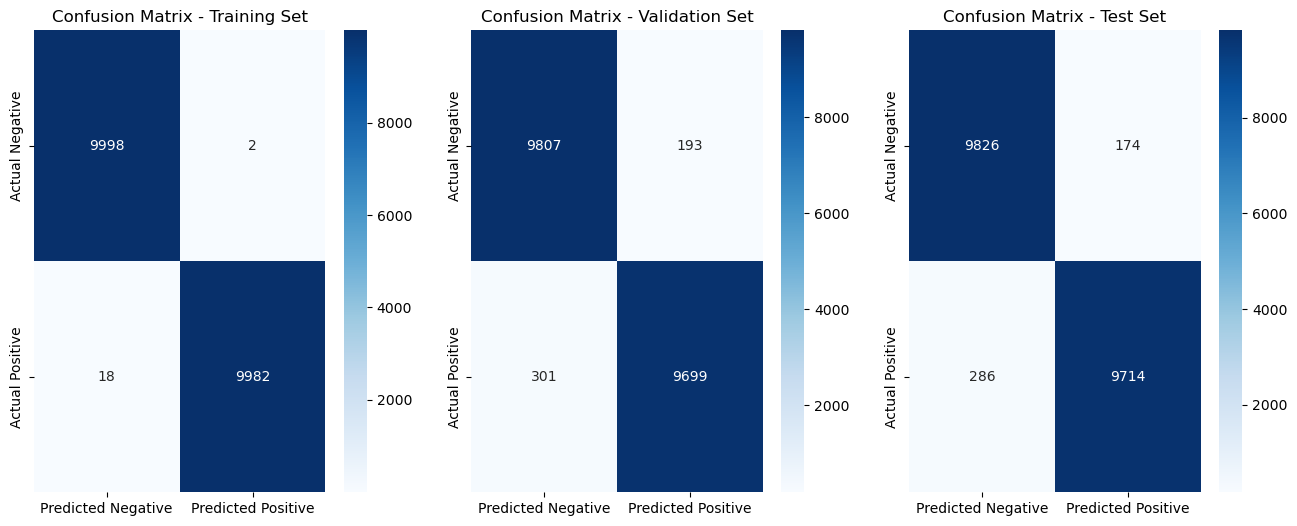

In [28]:
# predict values and confusion matrix
prediction2=prediction_confmatrix(model2)

In [67]:
# save whole model
model2.save("finalModelMobileNetV2")
model2.save("finalModelMobileNetV2.h5")
#save only weights
model2.save_weights('finalModelMobileNetV2.h5')

INFO:tensorflow:Assets written to: finalModelMobileNetV2\assets


INFO:tensorflow:Assets written to: finalModelMobileNetV2\assets


 batch size==8

In [29]:
# Compile the model
optimizer = Adam(learning_rate=1e-4)
# Define early stopping callback.
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

In [30]:
# Load the MobileNetV2 model without the top (classification) layers
base_model3 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Add custom top layers for classification
model3 = Sequential()
model3.add(base_model3)
model3.add(GlobalAveragePooling2D())
model3.add(Dense(256, activation='relu'))
model3.add(Dense(1, activation='sigmoid'))
model3.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 256)               327936    
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 2,586,177
Trainable params: 2,552,065
Non-trainable params: 34,112
_________________________________________________________________


In [31]:

# Compile the model
model3.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history3 = model3.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=8, callbacks=[lr_scheduler,early_stopping])


Epoch 1/20
2500/2500 [==============================] - 851s 306ms/step - loss: 0.3761 - accuracy: 0.8286 - val_loss: 0.2494 - val_accuracy: 0.9033 - lr: 1.0000e-04
Epoch 2/20
2500/2500 [==============================] - 617s 247ms/step - loss: 0.2108 - accuracy: 0.9183 - val_loss: 0.3412 - val_accuracy: 0.8777 - lr: 9.5000e-05
Epoch 3/20
2500/2500 [==============================] - 607s 243ms/step - loss: 0.1294 - accuracy: 0.9505 - val_loss: 0.1857 - val_accuracy: 0.9234 - lr: 9.0250e-05
Epoch 4/20
2500/2500 [==============================] - 606s 243ms/step - loss: 0.0874 - accuracy: 0.9675 - val_loss: 0.1363 - val_accuracy: 0.9502 - lr: 8.5737e-05
Epoch 5/20
2500/2500 [==============================] - 605s 242ms/step - loss: 0.0574 - accuracy: 0.9803 - val_loss: 0.1772 - val_accuracy: 0.9497 - lr: 8.1451e-05
Epoch 6/20
2500/2500 [==============================] - 603s 241ms/step - loss: 0.0498 - accuracy: 0.9837 - val_loss: 0.1161 - val_accuracy: 0.9572 - lr: 7.7378e-05
Epoch 7/20

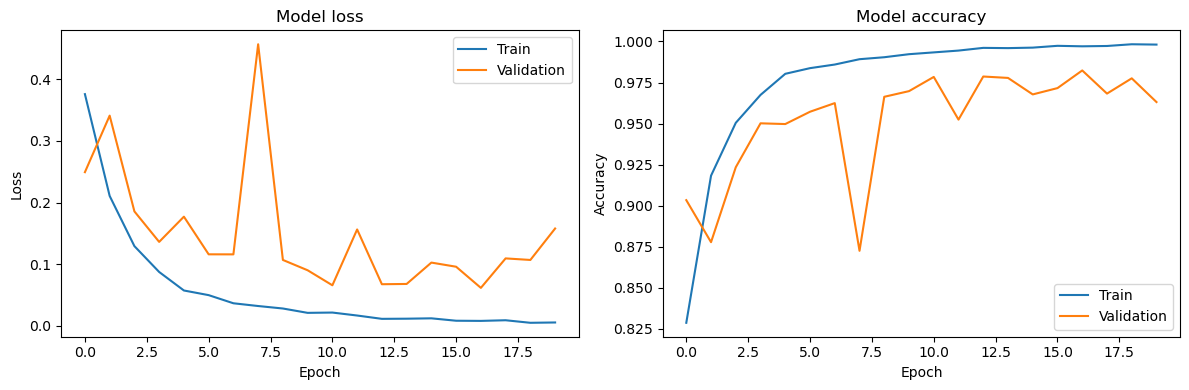

In [32]:
# Plot the learning curve
plot_learning_curve(history3)

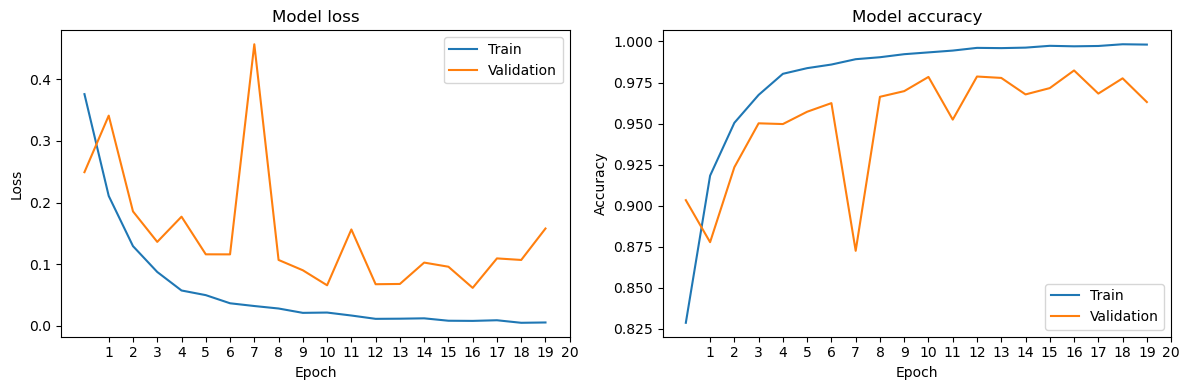

In [36]:
import matplotlib.pyplot as plt

def plot_learning_curvei(history):
    plt.figure(figsize=(12, 4))

    # Plot training & validation loss values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.xticks(range(1, len(history.history['loss']) + 1))  # Set x-axis ticks as integers
    plt.legend(['Train', 'Validation'], loc='upper right')

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.xticks(range(1, len(history.history['accuracy']) + 1))  # Set x-axis ticks as integers
    plt.legend(['Train', 'Validation'], loc='lower right')

    plt.tight_layout()
    plt.show()

# Example usage:
plot_learning_curvei(history3)


In [33]:
# evaluate the model in test data
evaluation3=evaluate_test(model3)

625/625 [==============================] - 81s 117ms/step
Test Loss: 0.16177354753017426
Test Accuracy: 0.9621999859809875
Test Accuracy: 96.22%


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.93      0.96     10000
           1       0.93      0.99      0.96     10000

    accuracy                           0.96     20000
   macro avg       0.96      0.96      0.96     20000
weighted avg       0.96      0.96      0.96     20000



625/625 [==============================] - 77s 121ms/step
Confusion Matrix - Training Set:
[[ 9915    85]
 [    0 10000]]
Confusion Matrix - Validation Set:
[[9301  699]
 [  39 9961]]
Confusion Matrix - Test Set:
[[9300  700]
 [  56 9944]]


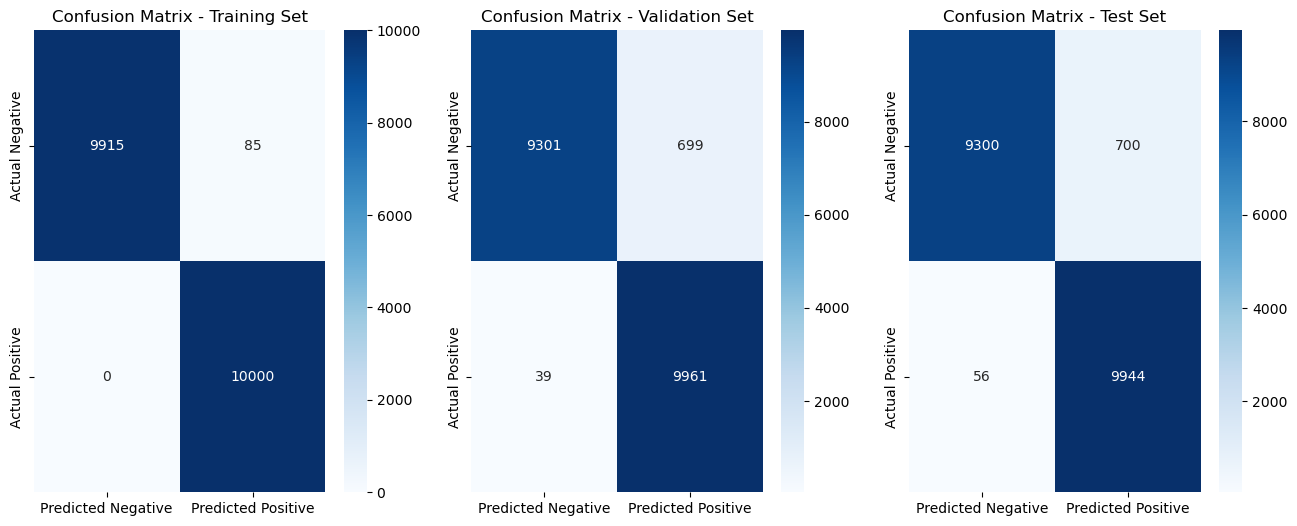

In [78]:
# predict values and confusion matrix
prediction3=prediction_confmatrix(model3)

In [ ]:
# save whole model
model3.save("MobileNetV2model3largescale8batch")
model3.save("MobileNetV2model3withlargescale8batch.h5")
#save only weights
model3.save_weights('MobileNetV2model3weightslargescale8batch.h5')

comparison

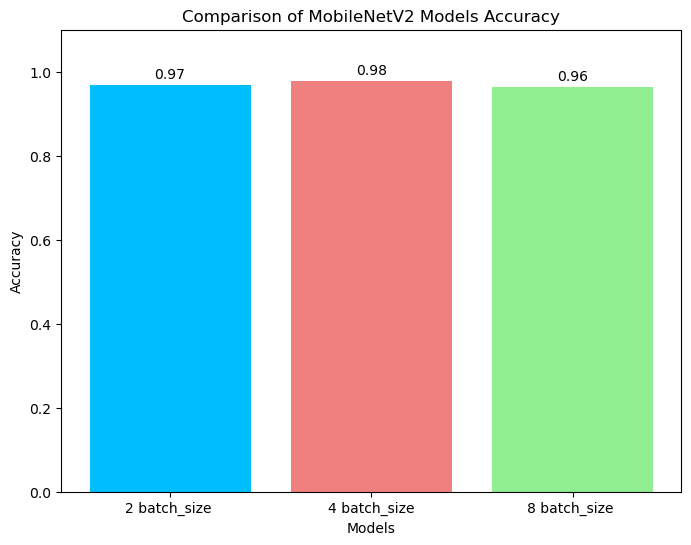

In [57]:

# Sample data for three models
models = ['2 batch_size ', '4 batch_size', '8 batch_size ']
accuracy = [evaluation1[1],evaluation2[1],evaluation3[1]]

# Bar chart
plt.figure(figsize=(8, 6))
plt.bar(models, accuracy, color=['deepskyblue','lightcoral', 'lightgreen' ])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of MobileNetV2 Models Accuracy')
plt.ylim(0, 1.1)  # Set y-axis range if needed


# Display the values on top of the bars
for i, value in enumerate(accuracy):
    plt.text(i, value + 0.01, f'{value:.2f}', ha='center', va='bottom')

# Show the plot
plt.show()

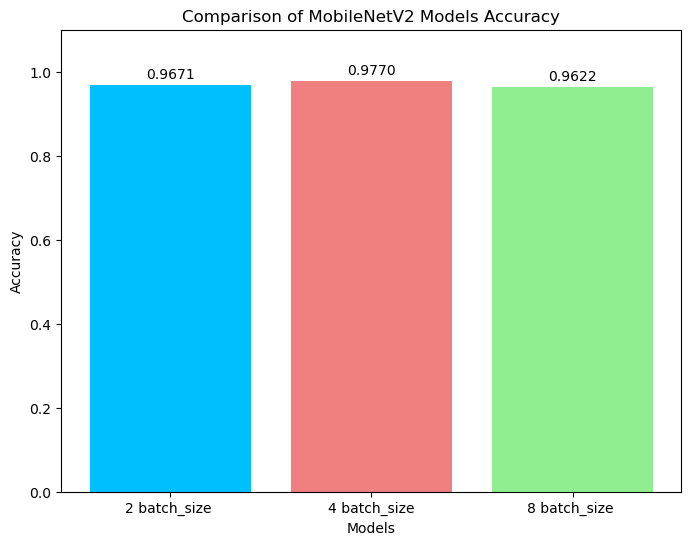

In [59]:
import matplotlib.pyplot as plt

# Sample data for three models
models = ['2 batch_size ', '4 batch_size', '8 batch_size ']
accuracy = [evaluation1[1], evaluation2[1], evaluation3[1]]

# Bar chart
plt.figure(figsize=(8, 6))
bars = plt.bar(models, accuracy, color=['deepskyblue', 'lightcoral', 'lightgreen'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of MobileNetV2 Models Accuracy')
plt.ylim(0, 1.1)  # Set y-axis range slightly above 1 for better visualization

# Display the values on top of the bars without rounding
for bar, value in zip(bars, accuracy):
    plt.text(bar.get_x() + bar.get_width() / 2, min(value + 0.01, 1), f'{value:.4f}', ha='center', va='bottom')

# Show the plot
plt.show()


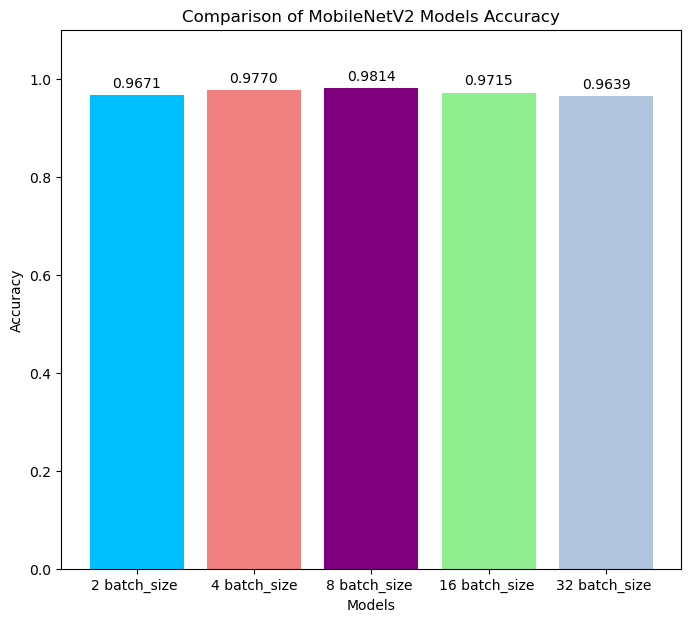

In [76]:

# Sample data for three models
models = ['2 batch_size ', '4 batch_size', '8 batch_size ' ,'16 batch_size ','32 batch_size ']
accuracy = [0.9671499729156494, 0.9769999980926514, 0.9813500046730042,0.9714999794960022, 0.9639000296592712]

# Bar chart
plt.figure(figsize=(8, 7))
bars = plt.bar(models, accuracy, color=['deepskyblue', 'lightcoral','purple', 'lightgreen' ,'lightsteelblue'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of MobileNetV2 Models Accuracy')
plt.ylim(0, 1.1)  # Set y-axis range slightly above 1 for better visualization

# Display the values on top of the bars without rounding
for bar, value in zip(bars, accuracy):
    plt.text(bar.get_x() + bar.get_width() / 2, min(value + 0.01, 1), f'{value:.4f}', ha='center', va='bottom')

# Show the plot
plt.show()

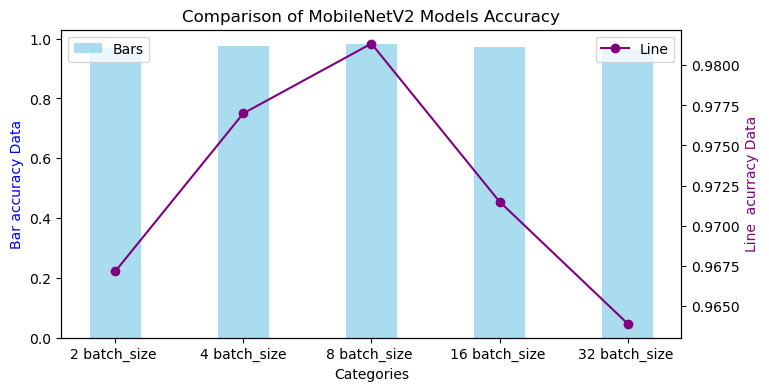

In [77]:
import matplotlib.pyplot as plt
import numpy as np

# Generate sample data
categories = ['2 batch_size ', '4 batch_size', '8 batch_size ' ,'16 batch_size ','32 batch_size ']
bar_data = [0.9671499729156494, 0.9769999980926514,  0.9813500046730042,0.9714999794960022, 0.9639000296592712]
line_data = [0.9671499729156494, 0.9769999980926514,  0.9813500046730042,0.9714999794960022, 0.9639000296592712]

# Create figure and axes
fig, ax1 = plt.subplots(figsize=(8, 4))

# Plot bars with baby blue color and less width
ax1.bar(categories, bar_data, color='skyblue', width=0.4, alpha=0.7, label='Bars')

# Create a secondary y-axis for the line chart
ax2 = ax1.twinx()

# Plot line chart
ax2.plot(categories, line_data, color='purple', marker='o', label='Line')

# Set labels and title
ax1.set_xlabel('Categories')
ax1.set_ylabel('Bar accuracy Data', color='blue')
ax2.set_ylabel('Line  acurracy Data', color='purple')
plt.title('Comparison of MobileNetV2 Models Accuracy')

# Display legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()